In [11]:
from sklearn.cluster import KMeans
from semi_supervised_clustering import *

In [2]:
x_train, y_train, x_test, y_test = mnist_data(categorical=True)
# percentages = [0.01, 0.05, 0.1, 0.2, 0.5]
labeled_data, labeled_labels, unlabeled_data, unlabeled_labels = prepare_labeled_data(x_train, y_train, percentage=0.01)
X = np.concatenate((labeled_data, unlabeled_data), axis=0)
label_assignments = list(labeled_labels) + list(unlabeled_labels)

In [3]:
print(X.shape)
print(len(labeled_data), len(labeled_labels))
print(set(labeled_labels), set(y_train))

(60000, 784)
600 600
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9} {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


# trival

In [20]:
kmeans = KMeans(n_clusters=10, random_state=0)  # assuming 3 clusters
kmeans.fit(X)
cluster_assignments, centroids = kmeans.labels_, kmeans.cluster_centers_

In [21]:
print(cluster_assignments[600:700])

[6 1 9 8 5 1 1 1 1 2 0 9 5 3 2 0 8 7 1 7 6 8 5 7 2 7 2 2 9 5 1 3 2 7 5 9 8
 8 1 4 8 0 8 7 1 1 2 8 8 8 8 8 9 5 9 6 4 9 2 2 1 4 1 7 4 8 9 2 6 5 2 1 8 0
 2 3 5 5 2 4 3 5 5 7 6 1 9 7 2 7 6 1 9 0 9 1 1 7 8 7]


/home/congyu/anaconda3/envs/congyuAI/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/congyu/anaconda3/envs/congyuAI/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


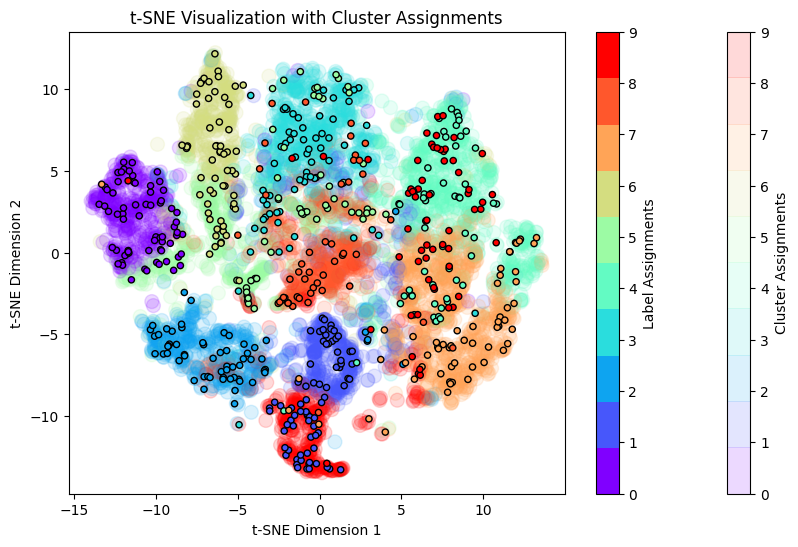

In [22]:
CopKMean.scatter_cluster_points_with_labeled(X, label_assignments, cluster_assignments, n_labeled=len(labeled_labels))

# semi-supervised

In [23]:
Method = CopKMean
must_link, cannot_link = Method.labels_to_constraints(labeled_labels)
# Method = CopKMean_Behrouz
# must_link, cannot_link = Method.label_to_constraints(labeled_labels, len(X))
cluster_assignments, centroids = Method.fit_transform(X, 10, must_link, cannot_link, verbose=True)

assign cluster index:   0%|          | 0/60000 [00:00<?, ?it/s]


initializing centroids...


assign cluster index:   0%|          | 0/60000 [00:00<?, ?it/s]


updated centroids with total distance as: 55.2/6.73e-06


assign cluster index:   1%|          | 597/60000 [00:00<00:09, 5941.60it/s]

updated centroids with total distance as: 8.94/6.73e-06



assign cluster index:   0%|          | 0/60000 [00:00<?, ?it/s]


updated centroids with total distance as: 6.24/6.73e-06


assign cluster index:   0%|          | 0/60000 [00:00<?, ?it/s]

updated centroids with total distance as: 4.7/6.73e-06



assign cluster index:   0%|          | 0/60000 [00:00<?, ?it/s]

updated centroids with total distance as: 3.53/6.73e-06



assign cluster index:   0%|          | 0/60000 [00:00<?, ?it/s]


updated centroids with total distance as: 2.52/6.73e-06


assign cluster index:   0%|          | 0/60000 [00:00<?, ?it/s]

updated centroids with total distance as: 1.77/6.73e-06



assign cluster index:   1%|          | 553/60000 [00:00<00:10, 5526.50it/s]

updated centroids with total distance as: 1.3/6.73e-06



assign cluster index:   1%|          | 568/60000 [00:00<00:10, 5669.52it/s]

updated centroids with total distance as: 0.89/6.73e-06



assign cluster index:   0%|          | 0/60000 [00:00<?, ?it/s]

updated centroids with total distance as: 0.6/6.73e-06



assign cluster index:   0%|          | 0/60000 [00:00<?, ?it/s]

updated centroids with total distance as: 0.409/6.73e-06



assign cluster index:   1%|          | 577/60000 [00:00<00:10, 5753.19it/s]

updated centroids with total distance as: 0.312/6.73e-06



assign cluster index:   1%|          | 571/60000 [00:00<00:10, 5709.23it/s]

updated centroids with total distance as: 0.222/6.73e-06



assign cluster index:   4%|▎         | 2206/60000 [00:00<00:02, 22059.97it/s]

updated centroids with total distance as: 0.166/6.73e-06



assign cluster index:   1%|          | 588/60000 [00:00<00:10, 5858.12it/s]

updated centroids with total distance as: 0.145/6.73e-06



assign cluster index:   2%|▏         | 1308/60000 [00:00<00:04, 13079.92it/s]

updated centroids with total distance as: 0.141/6.73e-06



assign cluster index:   1%|          | 628/60000 [00:00<00:09, 6279.66it/s]

updated centroids with total distance as: 0.12/6.73e-06



assign cluster index:   1%|          | 460/60000 [00:00<00:12, 4583.52it/s]

updated centroids with total distance as: 0.231/6.73e-06



assign cluster index:   0%|          | 0/60000 [00:00<?, ?it/s]

updated centroids with total distance as: 0.123/6.73e-06



assign cluster index:   1%|          | 444/60000 [00:00<00:13, 4439.16it/s]

updated centroids with total distance as: 0.0837/6.73e-06



assign cluster index:   1%|          | 699/60000 [00:00<00:08, 6989.79it/s]

updated centroids with total distance as: 0.0728/6.73e-06



assign cluster index:   1%|          | 587/60000 [00:00<00:10, 5853.54it/s]

updated centroids with total distance as: 0.0423/6.73e-06



assign cluster index:   1%|          | 562/60000 [00:00<00:10, 5600.76it/s]

updated centroids with total distance as: 0.039/6.73e-06



assign cluster index:   0%|          | 0/60000 [00:00<?, ?it/s]


updated centroids with total distance as: 0.0239/6.73e-06


assign cluster index:   1%|          | 571/60000 [00:00<00:10, 5691.94it/s]

updated centroids with total distance as: 0.0236/6.73e-06



assign cluster index:   1%|          | 567/60000 [00:00<00:10, 5659.49it/s]

updated centroids with total distance as: 0.0292/6.73e-06



assign cluster index:   0%|          | 0/60000 [00:00<?, ?it/s]

updated centroids with total distance as: 0.0389/6.73e-06



assign cluster index:   0%|          | 0/60000 [00:00<?, ?it/s]

updated centroids with total distance as: 0.0401/6.73e-06



assign cluster index:   0%|          | 0/60000 [00:00<?, ?it/s]

updated centroids with total distance as: 0.0449/6.73e-06



assign cluster index:   0%|          | 0/60000 [00:00<?, ?it/s]


updated centroids with total distance as: 0.0537/6.73e-06


assign cluster index:   1%|          | 569/60000 [00:00<00:10, 5680.16it/s]

updated centroids with total distance as: 0.0479/6.73e-06



assign cluster index:   2%|▏         | 1060/60000 [00:00<00:05, 10599.86it/s]

updated centroids with total distance as: 0.0402/6.73e-06



assign cluster index:   0%|          | 0/60000 [00:00<?, ?it/s]


updated centroids with total distance as: 0.04/6.73e-06


assign cluster index:   1%|          | 687/60000 [00:00<00:08, 6869.34it/s]

updated centroids with total distance as: 0.0277/6.73e-06



assign cluster index:   1%|          | 540/60000 [00:00<00:11, 5365.81it/s]

updated centroids with total distance as: 0.0325/6.73e-06



assign cluster index:   1%|          | 585/60000 [00:00<00:10, 5837.09it/s]

updated centroids with total distance as: 0.0205/6.73e-06



assign cluster index:   3%|▎         | 1865/60000 [00:00<00:03, 18649.35it/s]

updated centroids with total distance as: 0.00912/6.73e-06



assign cluster index:   1%|          | 568/60000 [00:00<00:10, 5674.66it/s]

updated centroids with total distance as: 0.0065/6.73e-06



assign cluster index:   1%|          | 498/60000 [00:00<00:11, 4978.21it/s]

updated centroids with total distance as: 0.00529/6.73e-06



assign cluster index:   2%|▏         | 1135/60000 [00:00<00:05, 11349.39it/s]

updated centroids with total distance as: 0.0109/6.73e-06



assign cluster index:   4%|▍         | 2307/60000 [00:00<00:02, 23069.58it/s]

updated centroids with total distance as: 0.0115/6.73e-06



assign cluster index:   1%|          | 572/60000 [00:00<00:10, 5709.71it/s]

updated centroids with total distance as: 0.0188/6.73e-06



assign cluster index:   0%|          | 0/60000 [00:00<?, ?it/s]


updated centroids with total distance as: 0.0217/6.73e-06


assign cluster index:   1%|          | 548/60000 [00:00<00:10, 5457.48it/s]

updated centroids with total distance as: 0.0282/6.73e-06



assign cluster index:   6%|▌         | 3485/60000 [00:00<00:01, 34849.70it/s]

updated centroids with total distance as: 0.0202/6.73e-06



assign cluster index:   1%|          | 600/60000 [00:00<00:09, 5991.76it/s]

updated centroids with total distance as: 0.0226/6.73e-06



assign cluster index:   1%|          | 593/60000 [00:00<00:10, 5912.32it/s]

updated centroids with total distance as: 0.0273/6.73e-06



assign cluster index:   4%|▍         | 2261/60000 [00:00<00:02, 22609.16it/s]

updated centroids with total distance as: 0.0297/6.73e-06



assign cluster index:   0%|          | 0/60000 [00:00<?, ?it/s]


updated centroids with total distance as: 0.026/6.73e-06


assign cluster index:   1%|          | 598/60000 [00:00<00:09, 5971.28it/s]

updated centroids with total distance as: 0.0151/6.73e-06



assign cluster index:   4%|▍         | 2492/60000 [00:00<00:02, 24919.37it/s]

updated centroids with total distance as: 0.0194/6.73e-06



assign cluster index:   1%|          | 568/60000 [00:00<00:10, 5668.05it/s]

updated centroids with total distance as: 0.0202/6.73e-06



assign cluster index:   0%|          | 0/60000 [00:00<?, ?it/s]

updated centroids with total distance as: 0.0114/6.73e-06



assign cluster index:   0%|          | 0/60000 [00:00<?, ?it/s]


updated centroids with total distance as: 0.00949/6.73e-06


assign cluster index:   1%|          | 491/60000 [00:00<00:12, 4905.78it/s]

updated centroids with total distance as: 0.0117/6.73e-06



assign cluster index:   1%|          | 713/60000 [00:00<00:08, 7129.67it/s]

updated centroids with total distance as: 0.00772/6.73e-06



iterations:  19%|█▊        | 56/300 [00:28<02:05,  1.95it/s]

updated centroids with total distance as: 7.1e-07/6.73e-06


In [24]:
print(cluster_assignments[600:700])

[0 9 3 2 6 9 9 9 9 8 5 3 6 1 8 5 2 7 9 1 0 2 6 7 8 0 8 8 3 6 9 1 8 0 6 4 7
 2 9 7 2 5 2 6 9 9 8 2 2 2 2 2 3 6 3 0 4 3 8 8 9 4 9 7 4 2 3 8 0 6 8 9 2 5
 8 1 6 6 8 4 1 6 6 8 0 9 3 0 8 0 0 9 3 5 3 9 9 7 2 8]


In [25]:
# label_assignments = list(labeled_labels) + list(unlabeled_labels)
# Method.scatter_cluster_points_with_labeled(X, label_assignments, labeled_labels)

/home/congyu/anaconda3/envs/congyuAI/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/congyu/anaconda3/envs/congyuAI/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


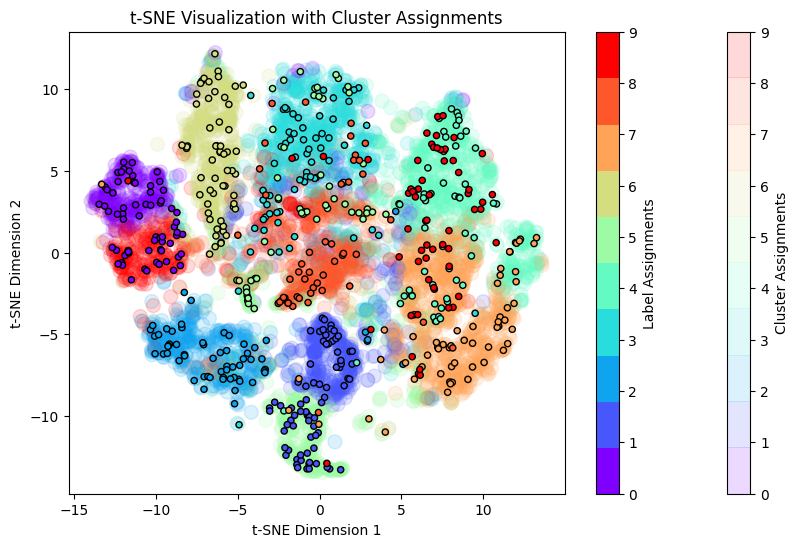

In [26]:
Method.scatter_cluster_points_with_labeled(X, label_assignments, cluster_assignments, n_labeled=len(labeled_labels))

# semi-supervised

In [27]:
Method = CopKMean_Behrouz
must_link, cannot_link = Method.labels_to_constraints(labeled_labels, len(X))
cluster_assignments, centroids = Method.fit_transform(X, 10, must_link, cannot_link, verbose=True)

scan all points for grouping:  56%|█████▌    | 33383/60000 [00:00<00:00, 189044.75it/s]

optimize must_link info ...


initialize centroids:   0%|          | 0/9 [00:00<?, ?it/s]

initializing centroids...


assign cluster index:   7%|▋         | 4092/60000 [00:00<00:01, 40918.28it/s]

updated centroids with total distance as: 50.1/6.73e-06



assign cluster index:   7%|▋         | 4005/60000 [00:00<00:01, 40043.16it/s]

updated centroids with total distance as: 9.09/6.73e-06



assign cluster index:   7%|▋         | 4195/60000 [00:00<00:01, 41949.34it/s]

updated centroids with total distance as: 4.93/6.73e-06



assign cluster index:   7%|▋         | 4228/60000 [00:00<00:01, 42272.38it/s]

updated centroids with total distance as: 2.59/6.73e-06



assign cluster index:   7%|▋         | 4190/60000 [00:00<00:01, 41890.75it/s]

updated centroids with total distance as: 1.47/6.73e-06



assign cluster index:   7%|▋         | 4488/60000 [00:00<00:01, 44879.61it/s]

updated centroids with total distance as: 0.796/6.73e-06



assign cluster index:   7%|▋         | 4398/60000 [00:00<00:01, 43979.73it/s]

updated centroids with total distance as: 0.473/6.73e-06



assign cluster index:   8%|▊         | 4508/60000 [00:00<00:01, 45079.08it/s]

updated centroids with total distance as: 0.327/6.73e-06



assign cluster index:   7%|▋         | 4279/60000 [00:00<00:01, 42779.84it/s]

updated centroids with total distance as: 0.257/6.73e-06



assign cluster index:   7%|▋         | 4431/60000 [00:00<00:01, 44303.60it/s]

updated centroids with total distance as: 0.203/6.73e-06



assign cluster index:   7%|▋         | 4369/60000 [00:00<00:01, 43680.98it/s]

updated centroids with total distance as: 0.159/6.73e-06



assign cluster index:   7%|▋         | 4432/60000 [00:00<00:01, 44313.07it/s]

updated centroids with total distance as: 0.146/6.73e-06



assign cluster index:   7%|▋         | 4376/60000 [00:00<00:01, 43753.89it/s]

updated centroids with total distance as: 0.131/6.73e-06



assign cluster index:   7%|▋         | 4326/60000 [00:00<00:01, 43253.44it/s]

updated centroids with total distance as: 0.139/6.73e-06



assign cluster index:   7%|▋         | 4409/60000 [00:00<00:01, 44079.74it/s]

updated centroids with total distance as: 0.143/6.73e-06



assign cluster index:   7%|▋         | 4255/60000 [00:00<00:01, 42543.24it/s]

updated centroids with total distance as: 0.157/6.73e-06



assign cluster index:   7%|▋         | 3932/60000 [00:00<00:01, 39313.38it/s]

updated centroids with total distance as: 0.152/6.73e-06



assign cluster index:   7%|▋         | 4063/60000 [00:00<00:01, 40615.51it/s]

updated centroids with total distance as: 0.161/6.73e-06



assign cluster index:   7%|▋         | 4045/60000 [00:00<00:01, 40446.66it/s]

updated centroids with total distance as: 0.166/6.73e-06



assign cluster index:   7%|▋         | 4037/60000 [00:00<00:01, 40367.82it/s]

updated centroids with total distance as: 0.187/6.73e-06



assign cluster index:   7%|▋         | 4050/60000 [00:00<00:01, 40495.79it/s]

updated centroids with total distance as: 0.194/6.73e-06



assign cluster index:   7%|▋         | 3904/60000 [00:00<00:01, 39034.83it/s]

updated centroids with total distance as: 0.199/6.73e-06



assign cluster index:   7%|▋         | 4070/60000 [00:00<00:01, 40693.05it/s]

updated centroids with total distance as: 0.21/6.73e-06



assign cluster index:   7%|▋         | 3938/60000 [00:00<00:01, 39365.02it/s]

updated centroids with total distance as: 0.324/6.73e-06



assign cluster index:   7%|▋         | 4250/60000 [00:00<00:01, 42493.66it/s]

updated centroids with total distance as: 0.243/6.73e-06



assign cluster index:   6%|▋         | 3872/60000 [00:00<00:01, 38714.31it/s]

updated centroids with total distance as: 0.263/6.73e-06



assign cluster index:   7%|▋         | 4087/60000 [00:00<00:01, 40862.44it/s]

updated centroids with total distance as: 0.293/6.73e-06



assign cluster index:   7%|▋         | 4301/60000 [00:00<00:01, 43002.04it/s]

updated centroids with total distance as: 0.256/6.73e-06



assign cluster index:   7%|▋         | 4135/60000 [00:00<00:01, 41348.66it/s]

updated centroids with total distance as: 0.226/6.73e-06



assign cluster index:   7%|▋         | 4060/60000 [00:00<00:01, 40596.75it/s]

updated centroids with total distance as: 0.225/6.73e-06



assign cluster index:   7%|▋         | 4146/60000 [00:00<00:01, 41455.39it/s]

updated centroids with total distance as: 0.23/6.73e-06



assign cluster index:   6%|▌         | 3657/60000 [00:00<00:01, 36561.84it/s]

updated centroids with total distance as: 0.22/6.73e-06



assign cluster index:   7%|▋         | 4159/60000 [00:00<00:01, 41584.69it/s]

updated centroids with total distance as: 0.207/6.73e-06



assign cluster index:   7%|▋         | 4316/60000 [00:00<00:01, 43156.95it/s]

updated centroids with total distance as: 0.233/6.73e-06



assign cluster index:   7%|▋         | 4292/60000 [00:00<00:01, 42918.51it/s]

updated centroids with total distance as: 0.223/6.73e-06



assign cluster index:   7%|▋         | 4259/60000 [00:00<00:01, 42588.11it/s]

updated centroids with total distance as: 0.202/6.73e-06



assign cluster index:   7%|▋         | 4296/60000 [00:00<00:01, 42950.82it/s]

updated centroids with total distance as: 0.207/6.73e-06



assign cluster index:   7%|▋         | 4192/60000 [00:00<00:01, 41914.64it/s]

updated centroids with total distance as: 0.193/6.73e-06



assign cluster index:   6%|▌         | 3396/60000 [00:00<00:01, 33952.75it/s]

updated centroids with total distance as: 0.197/6.73e-06



assign cluster index:   6%|▌         | 3373/60000 [00:00<00:01, 33729.95it/s]

updated centroids with total distance as: 0.206/6.73e-06



assign cluster index:   7%|▋         | 4234/60000 [00:00<00:01, 42337.72it/s]

updated centroids with total distance as: 0.18/6.73e-06



assign cluster index:   7%|▋         | 4317/60000 [00:00<00:01, 43169.73it/s]

updated centroids with total distance as: 0.195/6.73e-06



assign cluster index:   7%|▋         | 3941/60000 [00:00<00:01, 39402.05it/s]

updated centroids with total distance as: 0.204/6.73e-06



assign cluster index:   7%|▋         | 4183/60000 [00:00<00:01, 41825.35it/s]

updated centroids with total distance as: 0.21/6.73e-06



assign cluster index:   7%|▋         | 4268/60000 [00:00<00:01, 42673.43it/s]

updated centroids with total distance as: 0.191/6.73e-06



assign cluster index:   7%|▋         | 4424/60000 [00:00<00:01, 44230.02it/s]

updated centroids with total distance as: 0.187/6.73e-06



assign cluster index:   7%|▋         | 4263/60000 [00:00<00:01, 42621.30it/s]

updated centroids with total distance as: 0.161/6.73e-06



assign cluster index:   7%|▋         | 4021/60000 [00:00<00:01, 40199.40it/s]

updated centroids with total distance as: 0.156/6.73e-06



assign cluster index:   7%|▋         | 3930/60000 [00:00<00:01, 39298.91it/s]

updated centroids with total distance as: 0.181/6.73e-06



assign cluster index:   6%|▋         | 3829/60000 [00:00<00:01, 38283.46it/s]

updated centroids with total distance as: 0.169/6.73e-06



assign cluster index:   7%|▋         | 3968/60000 [00:00<00:01, 39653.28it/s]

updated centroids with total distance as: 0.151/6.73e-06



assign cluster index:   7%|▋         | 4436/60000 [00:00<00:01, 44351.48it/s]

updated centroids with total distance as: 0.127/6.73e-06



assign cluster index:   7%|▋         | 4258/60000 [00:00<00:01, 42575.27it/s]

updated centroids with total distance as: 0.118/6.73e-06



assign cluster index:   7%|▋         | 4071/60000 [00:00<00:01, 40705.57it/s]

updated centroids with total distance as: 0.113/6.73e-06



assign cluster index:   6%|▌         | 3688/60000 [00:00<00:01, 36876.61it/s]

updated centroids with total distance as: 0.0932/6.73e-06



assign cluster index:   7%|▋         | 4064/60000 [00:00<00:01, 40636.74it/s]

updated centroids with total distance as: 0.0911/6.73e-06



assign cluster index:   7%|▋         | 4098/60000 [00:00<00:01, 40973.88it/s]

updated centroids with total distance as: 0.0739/6.73e-06



assign cluster index:   7%|▋         | 4114/60000 [00:00<00:01, 41137.29it/s]

updated centroids with total distance as: 0.0612/6.73e-06



assign cluster index:   5%|▍         | 2872/60000 [00:00<00:01, 28715.71it/s]

updated centroids with total distance as: 0.0601/6.73e-06



assign cluster index:   6%|▌         | 3584/60000 [00:00<00:01, 35836.53it/s]

updated centroids with total distance as: 0.0684/6.73e-06



assign cluster index:   6%|▋         | 3821/60000 [00:00<00:01, 38205.03it/s]

updated centroids with total distance as: 0.0577/6.73e-06



assign cluster index:   7%|▋         | 4362/60000 [00:00<00:01, 43614.53it/s]

updated centroids with total distance as: 0.0583/6.73e-06



assign cluster index:   7%|▋         | 4391/60000 [00:00<00:01, 43908.58it/s]

updated centroids with total distance as: 0.0536/6.73e-06



assign cluster index:   7%|▋         | 4418/60000 [00:00<00:01, 44176.67it/s]

updated centroids with total distance as: 0.0464/6.73e-06



assign cluster index:   7%|▋         | 4168/60000 [00:00<00:01, 41676.76it/s]

updated centroids with total distance as: 0.0394/6.73e-06



assign cluster index:   6%|▋         | 3883/60000 [00:00<00:01, 38829.39it/s]

updated centroids with total distance as: 0.0382/6.73e-06



assign cluster index:   6%|▌         | 3714/60000 [00:00<00:01, 37138.53it/s]

updated centroids with total distance as: 0.0428/6.73e-06



assign cluster index:   7%|▋         | 4277/60000 [00:00<00:01, 42763.72it/s]

updated centroids with total distance as: 0.0407/6.73e-06



assign cluster index:   7%|▋         | 4371/60000 [00:00<00:01, 43707.44it/s]

updated centroids with total distance as: 0.0503/6.73e-06



assign cluster index:   7%|▋         | 4369/60000 [00:00<00:01, 43687.54it/s]

updated centroids with total distance as: 0.0379/6.73e-06



assign cluster index:   7%|▋         | 4379/60000 [00:00<00:01, 43785.24it/s]

updated centroids with total distance as: 0.0358/6.73e-06



assign cluster index:   7%|▋         | 4436/60000 [00:00<00:01, 44350.53it/s]

updated centroids with total distance as: 0.0204/6.73e-06



assign cluster index:   7%|▋         | 3926/60000 [00:00<00:01, 39255.45it/s]

updated centroids with total distance as: 0.0179/6.73e-06



assign cluster index:   7%|▋         | 4317/60000 [00:00<00:01, 43164.48it/s]

updated centroids with total distance as: 0.0172/6.73e-06



assign cluster index:   7%|▋         | 4393/60000 [00:00<00:01, 43929.62it/s]

updated centroids with total distance as: 0.0189/6.73e-06



assign cluster index:   7%|▋         | 4453/60000 [00:00<00:01, 44525.69it/s]

updated centroids with total distance as: 0.0124/6.73e-06



assign cluster index:   6%|▋         | 3780/60000 [00:00<00:01, 37794.09it/s]

updated centroids with total distance as: 0.0144/6.73e-06



assign cluster index:   7%|▋         | 4067/60000 [00:00<00:01, 40665.09it/s]

updated centroids with total distance as: 0.00789/6.73e-06



assign cluster index:   7%|▋         | 4091/60000 [00:00<00:01, 40906.33it/s]

updated centroids with total distance as: 0.00416/6.73e-06



assign cluster index:   7%|▋         | 3918/60000 [00:00<00:01, 39178.73it/s]

updated centroids with total distance as: 0.0108/6.73e-06



assign cluster index:   6%|▌         | 3741/60000 [00:00<00:01, 37394.52it/s]

updated centroids with total distance as: 0.0112/6.73e-06



assign cluster index:   7%|▋         | 4024/60000 [00:00<00:01, 40233.04it/s]

updated centroids with total distance as: 0.00589/6.73e-06



assign cluster index:   7%|▋         | 4034/60000 [00:00<00:01, 40339.75it/s]

updated centroids with total distance as: 0.00926/6.73e-06



assign cluster index:   7%|▋         | 4170/60000 [00:00<00:01, 41694.47it/s]

updated centroids with total distance as: 0.00634/6.73e-06



assign cluster index:   7%|▋         | 4008/60000 [00:00<00:01, 40075.93it/s]

updated centroids with total distance as: 0.00509/6.73e-06



assign cluster index:   7%|▋         | 4478/60000 [00:00<00:01, 44777.37it/s]

updated centroids with total distance as: 0.00829/6.73e-06



assign cluster index:   7%|▋         | 4340/60000 [00:00<00:01, 43397.45it/s]

updated centroids with total distance as: 0.00438/6.73e-06



assign cluster index:   7%|▋         | 4412/60000 [00:00<00:01, 44117.94it/s]

updated centroids with total distance as: 0.00588/6.73e-06



assign cluster index:   7%|▋         | 4332/60000 [00:00<00:01, 43315.08it/s]

updated centroids with total distance as: 0.00643/6.73e-06



assign cluster index:   7%|▋         | 3906/60000 [00:00<00:01, 39053.33it/s]

updated centroids with total distance as: 0.00838/6.73e-06



assign cluster index:   7%|▋         | 4224/60000 [00:00<00:01, 42239.03it/s]

updated centroids with total distance as: 0.0116/6.73e-06



assign cluster index:   7%|▋         | 4469/60000 [00:00<00:01, 44680.14it/s]

updated centroids with total distance as: 0.0164/6.73e-06



assign cluster index:   7%|▋         | 3940/60000 [00:00<00:01, 39399.94it/s]

updated centroids with total distance as: 0.0135/6.73e-06



assign cluster index:   7%|▋         | 3903/60000 [00:00<00:01, 39018.78it/s]

updated centroids with total distance as: 0.0111/6.73e-06



assign cluster index:   6%|▌         | 3447/60000 [00:00<00:01, 34465.68it/s]

updated centroids with total distance as: 0.0124/6.73e-06



assign cluster index:   7%|▋         | 4290/60000 [00:00<00:01, 42894.83it/s]

updated centroids with total distance as: 0.0149/6.73e-06



assign cluster index:   7%|▋         | 4016/60000 [00:00<00:01, 40151.04it/s]

updated centroids with total distance as: 0.0164/6.73e-06



assign cluster index:   7%|▋         | 4278/60000 [00:00<00:01, 42774.13it/s]

updated centroids with total distance as: 0.0113/6.73e-06



assign cluster index:   7%|▋         | 3945/60000 [00:00<00:01, 39443.83it/s]

updated centroids with total distance as: 0.0159/6.73e-06



assign cluster index:   7%|▋         | 3905/60000 [00:00<00:01, 39047.24it/s]

updated centroids with total distance as: 0.00876/6.73e-06



assign cluster index:   6%|▌         | 3382/60000 [00:00<00:01, 33814.95it/s]

updated centroids with total distance as: 0.0136/6.73e-06



assign cluster index:   6%|▌         | 3582/60000 [00:00<00:01, 35807.57it/s]

updated centroids with total distance as: 0.011/6.73e-06



assign cluster index:   7%|▋         | 4256/60000 [00:00<00:01, 42553.85it/s]

updated centroids with total distance as: 0.00888/6.73e-06



assign cluster index:   7%|▋         | 4161/60000 [00:00<00:01, 41603.39it/s]

updated centroids with total distance as: 0.00617/6.73e-06



assign cluster index:   7%|▋         | 3998/60000 [00:00<00:01, 39979.47it/s]

updated centroids with total distance as: 0.00353/6.73e-06



assign cluster index:   7%|▋         | 3998/60000 [00:00<00:01, 39975.94it/s]

updated centroids with total distance as: 0.00593/6.73e-06



assign cluster index:   7%|▋         | 4065/60000 [00:00<00:01, 40647.42it/s]

updated centroids with total distance as: 0.00488/6.73e-06



iterations:  36%|███▌      | 107/300 [03:12<05:47,  1.80s/it]

updated centroids with total distance as: 1.14e-06/6.73e-06


In [29]:
print(cluster_assignments[600:700])

[6 8 9 7 0 8 8 8 8 3 1 9 0 2 3 1 7 5 8 5 6 7 0 5 3 5 3 3 9 0 8 2 3 5 0 9 7
 7 8 4 7 1 7 5 8 8 3 7 7 7 7 7 9 0 9 6 4 9 3 3 8 4 8 5 4 7 9 3 6 0 3 8 7 1
 3 2 0 0 3 4 2 0 0 5 6 8 9 5 3 5 6 8 9 1 9 8 8 5 7 5]


/home/congyu/anaconda3/envs/congyuAI/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/congyu/anaconda3/envs/congyuAI/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


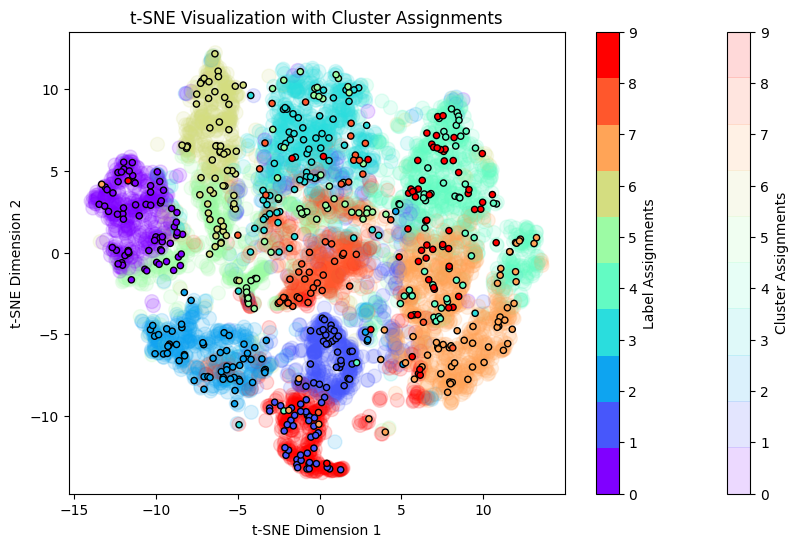

In [28]:
Method.scatter_cluster_points_with_labeled(X, label_assignments, cluster_assignments, n_labeled=len(labeled_labels))